Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

from pprint import pprint
import numpy as np
import pandas as pd
from scipy.optimize import minimize, basinhopping
from multiprocessing import Pool

from fisher_information import *
from QFIM_SMSV import QFIM_SMSV
from truncated_optimiser import *

Autosaving every 60 seconds


In [ ]:
# imports for plotting
import matplotlib.pyplot as plt

# LaTeX fonts
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
plt.rcParams.update({"font.size": 18})

# Bang Wong color blind--friendly colours
COLOURS = {
    "Black": "#000000",
    "Orange": "#E69F00",
    "Sky blue": "#56B4E9",
    "Bluish green": "#009E73",
    "Yellow": "#F0E442",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
    "Reddish purple": "#CC79A7",
}


def grid(ax):
    ax.grid("both", "both", color="gainsboro")

##### Set-up

TODO: extract these functions in to a separate file and make them pure, then set settings/parameters here only

In [2]:
# parameters
which = "QFI"
nbar0 = 0.5
eta_meas = 0.1
truncation_index = 2
settings = dict(
    sigma=0.001,
    delta_sigma=1e-10,
    loss_channel=lambda rho: loss_binomial(rho, eta_meas),
)


encoding_factory = lambda rho: lambda sigma: encoding_channel(
    rho,
    sigma,
    # analytic expansion only used 2nd order terms, let's try it here
    truncation_index,
    # timing similar to matrix exp
    # truncation_index=20,
)
FI_from_rho = lambda rho: FIs(
    encoding=encoding_factory(rho),
    # which="CFI",
    which=which,
    **settings,
)


def rho_from_diag(diag):
    """Returns rho for mixture of Fock states with given probabilities down the diagonal of the density matrix.

    Args:
        diag (Nmax-by-1): probabilities, zero-padded if shorter than required

    Raises:
        ValueError: if distribution is unnormalised.
    """
    # if sum(diag) != 1:
    #     raise ValueError("Unnormalised.")
    # pad with zeros if necessary
    if len(diag) < Nmax + 1:
        diag = np.concatenate(
            (
                diag,
                np.zeros(Nmax + 1 - len(diag)),
            )
        )
    return np.diag(diag)


def FI_from_diag(diag):
    """Returns FI for mixture of Fock states with given probabilities down the diagonal of the density matrix.

    Args:
        diag (Nmax-by-1): probabilities, zero-padded if shorter than required
    """
    rho = rho_from_diag(diag)
    return FI_from_rho(rho)


# minimise the negative FI = maximise the FI
fn = lambda diag: -FI_from_diag(diag)

# 'eq' constraints must be zero
normalisation_constraint = lambda probs: sum(probs) - 1
nbar_constraint = lambda probs: sum(np.arange(len(probs)) * probs) - nbar0
constraints = (
    {"type": "eq", "fun": normalisation_constraint},
    {"type": "eq", "fun": nbar_constraint},
)


def accept_test(**kwargs):
    """Returns whether to accept the step.

    Only runs after the first iteration. Could use "force accept" to increase temperature artifically.

    Args:
        x_new : new step location
    """
    do_print = False
    if do_print:
        print("\nEntering accept_test.")
    # constraints must be zero (within tolerance)
    constraint0 = normalisation_constraint(kwargs["x_new"])
    constraint1 = nbar_constraint(kwargs["x_new"])
    constraint_tol = 1e-10
    if abs(constraint0) < constraint_tol and abs(constraint1) < constraint_tol:
        if do_print:
            print("|    Satisfies constraints.")
        return True
    else:
        if do_print:
            print(
                f"|    Fails to satisfy all constraints.\n|    |    Satisfies: normalisation {constraint0}, nbar {constraint1}."
            )
        return False


def callback(x, f, accepted):
    """Prints the acceptance of the result after each local minimisation.

    Prints for all including the first (despite accept_test not being run there).

    TODO: set up my own tolerance condition using this feature from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
    "Also, callback can be used to specify a user defined stop criterion by optionally returning True to stop the basinhopping routine."

    Args:
        x (array): current args
        f (float): current fn value
        accepted (bool or "force accept"): whether accepted by accept_test + internal temperature check
    """
    # https://stackoverflow.com/a/48771519
    # TODO: fix this global
    global i_iteration_callback
    dp = 2
    x_formatted = [f"{v:.{dp}f}" for v in x]
    print(
        f"{i_iteration_callback}: {'Accepted' if accepted else 'Rejected'} the local minima of {f:.{dp}f} at {x_formatted}."
    )
    i_iteration_callback += 1


def diagonal_basin_hopping(x0, niter, constraints, do_callback=False, do_print=True):
    """Returns result from iterated local optimisation of the FI for mixed states down the Fock diagonal.

    Args:
        x0 (array): initial guess of probabilities. The length of x0 also sets the size of the bounded subspace.
        niter (int): number of steps, iterations after the first, for a total of niter+1 local minima
        do_callback (bool, optional): whether to print results after each outer iteration. Defaults to False.
    """
    bounds = [(0, 1) for _ in x0]

    # index for iterations
    if do_callback:
        i_iteration_callback = 0
    minimizer_kwargs = {"bounds": bounds, "constraints": constraints}

    res = basinhopping(
        fn,
        x0,
        minimizer_kwargs=minimizer_kwargs,
        niter=niter,
        accept_test=accept_test,
        # whether to print out the result of each iteration, needs i_iteration_callback = 0 set beforehand
        callback=callback if do_callback else None,
    )
    # print(res)
    if do_print:
        print(
            f"Optimal FI = {-res.fun:.2f} achieved at {[f'{v:.2f}' for v in res.x]} after {res.nit}/{niter} outer iterations."
        )
    if nbar0 == 0.5:
        if do_print:
            fifty_fifty = FI_from_diag([0.5, 0.5])
            print(
                f"Compare this to FI = {fifty_fifty:.2f} for the 50/50 mixture of 0 and 1."
            )
    return res


def diag_NN(nbar):
    """Returns probabilities for NN mixture. Works for integer values too (returns Fock state)."""
    n = int(np.floor(nbar))
    x = n + 1 - nbar
    # inds  = 0, 1, ..., n, n+1, n+2
    # probs = 0, 0, ..., x, 1-x, 0
    return np.concatenate([np.zeros(n), [x, 1 - x], np.zeros(Nmax - n - 1)])


def diagonal_basin_hopping_from_nbar(nbar):
    """nbar in (0,1) for x0 guess to start at NN"""
    nbar_constraint = lambda probs: sum(np.arange(len(probs)) * probs) - nbar
    constraints = (
        {"type": "eq", "fun": normalisation_constraint},
        {"type": "eq", "fun": nbar_constraint},
    )

    # need to allow one more than NN implies
    # this gets stuck at NN presently, so using a different x0 instead
    # x0 = diag_NN(nbar)[: int(np.ceil(1e-3) + 2)]
    x0 = [0.4, 0.5, 0.1]
    res = diagonal_basin_hopping(
        x0=x0, niter=10, do_print=False, constraints=constraints
    )

    return dict(nbar=nbar, FI=-res.fun, x=res.x)


def rho_from_DOF(dof):
    # TODO: automate this
    rho = (
        dof[0] * basis_element(0, 0)
        + dof[1] * basis_element(1, 1)
        + (1 - dof[0] - dof[1]) * basis_element(2, 2)
        # what are the constraints on this?
        + dof[2] * basis_element(0, 1)
        + np.conj(dof[2]) * basis_element(1, 0)
        + dof[3] * basis_element(0, 2)
        + np.conj(dof[3]) * basis_element(2, 0)
        + dof[4] * basis_element(1, 2)
        + np.conj(dof[4]) * basis_element(2, 1)
    )
    return rho

#### Generate data

Generate NN data
Nearest neighbour (NN) mixture

A different strategy: plot the FI for the NN mixture and see if displays the non-monotonic, spiky, but continuous behaviour that I suspect from the above results

In [16]:
# took 23 s
nbars = sorted(
    np.concatenate(
        [
            np.arange(0, 6 + 0.2, 0.2),
            *[np.arange(0, 6) + v for v in np.geomspace(1e-8, 1e-1, 8)],
        ]
    )
)
data = pd.DataFrame(
    np.empty((len(nbars), 2)),
    columns=["nbar", "FI"],
)
data["nbar"] = nbars
for i, nbar in enumerate(nbars):
    data["FI"].iloc[i] = FI_from_diag(diag_NN(nbar))

file = "./data/NN_versus_nbar.txt"
data.to_csv(file, index=False)

/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4


Generate large n NN data

In [19]:
# took 16 s
nbars = sorted(
    np.concatenate(
        [
            np.arange(0, 20 + 0.5, 0.5),
            np.arange(0, 20) + 1e-4,
        ]
    )
)
data2 = pd.DataFrame(
    np.empty((len(nbars), 2)),
    columns=["nbar", "FI"],
)
data2["nbar"] = nbars
for i, nbar in enumerate(nbars):
    data2["FI"].iloc[i] = FI_from_diag(diag_NN(nbar))

file = "./data/NN_versus_nbar_large_n.txt"
data2.to_csv(file, index=False)

/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4 * 3 / 2, 4 * 3 / 2), sharex=True)

c0, c1 = COLOURS["Orange"], COLOURS["Sky blue"]

axs[0].plot(df_lossy["n"], df_lossy["FI"], "x", color=c0, label="Fock states")
axs[1].semilogy(df_lossy["n"], df_lossy["FI"], "x", color=c0)

axs[0].plot(data2["nbar"], data2["FI"], ".-", color=c1, label="Nearest neighbour")
axs[1].semilogy(data2["nbar"], data2["FI"], ".-", color=c1)


h, l = axs[0].get_legend_handles_labels()
axs[1].legend(
    reversed(h),
    reversed(l),
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=18,
)

axs[0].set(
    xlim=(min(data2["nbar"]) - 0.05, max(data2["nbar"]) + 0.05),
    ylim=(0, None),
    ylabel="FI",
)
axs[1].set(
    xlabel=r"$\langle\hat n \rangle=\bar n$",
    ylabel="FI",
)
axs[0].set_title(
    "Nearest neighbour mixture of Fock states\n"
    + r"$p_{\lfloor\bar n\rfloor}=\lfloor\bar n\rfloor + 1 - \bar n$ and $p_{\lfloor\bar n\rfloor+1}=1-p_{\lfloor\bar n\rfloor}$"
    + "\nfor "
    + rf"$\sigma={settings['sigma']}, \eta_\mathrm{{meas}}={eta_meas}$"
)
axs[0].grid("both", "both", color="gainsboro")
axs[1].grid("both", "both", color="gainsboro")
fig.savefig("./figures/nearest_neighbour_Fock_mixture_large_n.pdf", bbox_inches="tight")

plt.show()

Generate BH (basin hopping) data

Includes nbar=1

I expect this to be poor since they do not find the NN or Fock state solutions well

This is most interesting just above a Fock state where NN does poorly

In [23]:
# takes >1 min
nbars = [1e-3, 0.1, 0.5, 1]

# leave one core to not crash the laptop
with Pool(3) as pool:
    # TODO: use imap_unordered instead since faster than pool.map
    results = pool.map(func=diagonal_basin_hopping_from_nbar, iterable=nbars)

pprint(results)

/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4
/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4
/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4


[{'FI': 0.011145493865834062,
  'nbar': 0.001,
  'x': array([9.995e-01, 0.000e+00, 5.000e-04])},
 {'FI': 0.21879605570689492,
  'nbar': 0.1,
  'x': array([9.50000000e-01, 3.33066907e-16, 5.00000000e-02])},
 {'FI': 1.6200112818942412, 'nbar': 0.5, 'x': array([0.5, 0.5, 0. ])},
 {'FI': 2.1870406148445807,
  'nbar': 1,
  'x': array([5.00000000e-01, 2.77555756e-16, 5.00000000e-01])}]


In [24]:
# results = [
#     {
#         "nbar": 0.001,
#         "FI": 0.011143871095537527,
#         "x": np.array([9.99500000e-01, 6.10622664e-16, 5.00000000e-04]),
#     },
#     {"nbar": 0.1, "FI": 0.21879381399105513, "x": np.array([0.95, 0.0, 0.05])},
#     {
#         "nbar": 0.5,
#         "FI": 1.0935306375951954,
#         "x": np.array([7.50000000e-01, 5.55111512e-17, 2.50000000e-01]),
#     },
# ]

data_bh = pd.DataFrame(
    np.empty((len(results), 2)),
    columns=["nbar", "FI"],
)

for i, result in enumerate(results):
    data_bh["nbar"].iloc[i] = result["nbar"]
    data_bh["FI"].iloc[i] = result["FI"]
    # TODO: fix pandas not happy with np.array as element, could spread across columns or call dtype?
    # data_bh["x"].iloc[i] = result["x"]

# export for plotting
file = "./data/basin_hopping_versus_nbar.txt"
data_bh.to_csv(file, index=False)

Analytics

In [18]:
ns = np.arange(0, 21, 1)
qfis = [2 * (1 - eta_meas) ** (n + 1) * (n + 1) for n in ns]
# plt.plot(ns, qfis)

#### Combined plot: NN, BH, Fock

Load data

In [3]:
# NN
file = "./data/NN_versus_nbar.txt"
data = pd.read_csv(file)

# NN, large n
file = "./data/NN_versus_nbar_large_n.txt"
data2 = pd.read_csv(file)

# mathematica results
file = "./data/Fock_versus_n.txt"
df_lossy = pd.read_csv(file, header=None, names=["n", "CFI"])

# basin hopping results (poor)
file = "./data/basin_hopping_versus_nbar.txt"
data_bh = pd.read_csv(file)

Plot

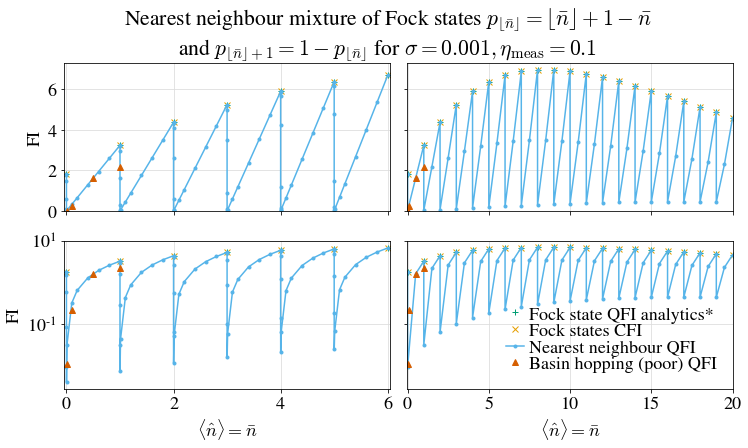

In [23]:
# TODO: execution order is poor, fix it or write documentation

fig, axs = plt.subplots(
    2,
    2,
    figsize=(2 * 4 * 3 / 2, 4 * 3 / 2),
    sharex="col",
    sharey="row",
    gridspec_kw={
        "wspace": 0.05,
        # "hspace": 0.05,
    },
)

c0, c1, c2 = COLOURS["Orange"], COLOURS["Sky blue"], COLOURS["Vermillion"]


# *with measurement loss added factor
axs[0, 0].plot(
    ns, qfis, "+", color=COLOURS["Bluish green"], label="Fock state QFI analytics*"
)
axs[1, 0].plot(ns, qfis, "+", color=COLOURS["Bluish green"])
axs[0, 1].plot(ns, qfis, "+", color=COLOURS["Bluish green"])
axs[1, 1].plot(ns, qfis, "+", color=COLOURS["Bluish green"])

axs[0, 0].plot(df_lossy["n"], df_lossy["CFI"], "x", color=c0, label="Fock states CFI")
axs[1, 0].semilogy(df_lossy["n"], df_lossy["CFI"], "x", color=c0)

axs[0, 0].plot(data["nbar"], data["FI"], ".-", color=c1, label="Nearest neighbour QFI")
axs[1, 0].semilogy(data["nbar"], data["FI"], ".-", color=c1)

axs[0, 0].plot(
    data_bh["nbar"], data_bh["FI"], "^", color=c2, label="Basin hopping (poor) QFI"
)
axs[1, 0].semilogy(data_bh["nbar"], data_bh["FI"], "^", color=c2)

h, l = axs[0, 0].get_legend_handles_labels()
axs[1, 1].legend(
    h,
    l,
    # reversed(h),
    # reversed(l),
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=18,
    # loc="upper left",
    loc="lower right",
)

axs[0, 0].set(
    xlim=(min(data["nbar"]) - 0.05, max(data["nbar"]) + 0.05),
    ylim=(0, None),
    ylabel="FI",
)
axs[1, 0].set(
    xlabel=r"$\langle\hat n \rangle=\bar n$",
    ylabel="FI",
)


# second columm
axs[0, 1].plot(df_lossy["n"], df_lossy["CFI"], "x", color=c0, label="Fock states")
axs[1, 1].semilogy(df_lossy["n"], df_lossy["CFI"], "x", color=c0)

axs[0, 1].plot(data2["nbar"], data2["FI"], ".-", color=c1, label="Nearest neighbour")
axs[1, 1].semilogy(data2["nbar"], data2["FI"], ".-", color=c1)

axs[0, 1].plot(
    data_bh["nbar"], data_bh["FI"], "^", color=c2, label="Basin hopping (poor)"
)
axs[1, 1].semilogy(data_bh["nbar"], data_bh["FI"], "^", color=c2)

axs[1, 1].set(
    xlim=(min(data2["nbar"]) - 0.05, max(data2["nbar"]) + 0.05),
    xlabel=r"$\langle\hat n \rangle=\bar n$",
)
fig.suptitle(
    "Nearest neighbour mixture of Fock states "
    + r"$p_{\lfloor\bar n\rfloor}=\lfloor\bar n\rfloor + 1 - \bar n$"
    + "\nand "
    + r"$p_{\lfloor\bar n\rfloor+1}=1-p_{\lfloor\bar n\rfloor}$"
    + " for "
    + rf"$\sigma={settings['sigma']}, \eta_\mathrm{{meas}}={eta_meas}$",
    y=1.01,
)
for ax in axs.flatten():
    grid(ax)
fig.savefig(
    "./figures/nearest_neighbour_Fock_mixture_combined.pdf", bbox_inches="tight"
)

plt.show()

Plot ratio

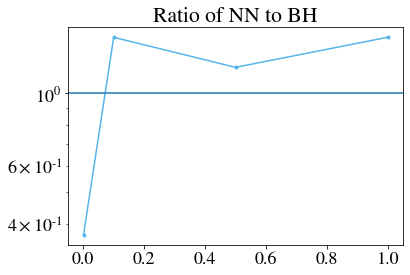

In [30]:
ratios = np.empty_like(data_bh["nbar"])
for i, nbar in enumerate(data_bh["nbar"]):
    ratios[i] = (
        data["FI"].iloc[np.searchsorted(data["nbar"], nbar)] / data_bh["FI"].iloc[i]
    )

plt.semilogy(
    data_bh["nbar"],
    ratios,
    ".-",
    color=c1,
    label="Ratio",
)
plt.axhline(1)
plt.title("Ratio of NN to BH")
plt.show()

#### Analytics

Sawtooth plot

In [38]:
d = np.linspace(0, 1, 20)
ns = np.arange(0, 40 + 1, 1)
eta = 0.1

focks = 2 * (1 - eta) ** ns * (ns + 1)

sticks = []
crossings = []
for n in ns:
    sticks.append(2 * (n + d) / (n + 1) * (1 - eta) ** (n + 1) * (n + 2))
    crossings.append((n + 1) ** 2 / ((n + 2) * (1 - eta)))
crossings = np.array(crossings)
crossings_proper = crossings[crossings - ns <= 1]
ns_crossings_proper = ns[crossings - ns <= 1]

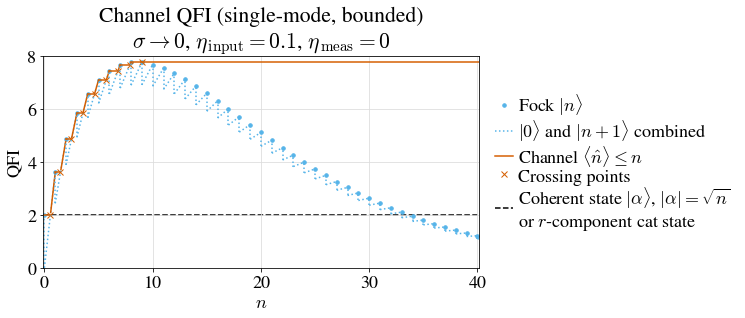

In [39]:
scale_factor = 1.3
fig, ax = plt.subplots(figsize=(6 * scale_factor, 3 * scale_factor))

xlim = (min(ns) - 0.1, max(ns) + 0.1)
ylim = (0, 8)

ax.plot(
    ns, focks, ".", markersize=7, color=COLOURS["Sky blue"], label=r"Fock $|n\rangle$"
)
ax.plot(
    crossings_proper,
    focks[crossings - ns <= 1],
    "x",
    color=COLOURS["Vermillion"],
    label="Crossing points",
)
for i, stick in enumerate(sticks):
    ax.plot(
        d + i,
        stick,
        linestyle=":",
        color=COLOURS["Sky blue"],
        label=r"$|0\rangle$ and $|n+1\rangle$ combined" if i == 0 else "",
    )
    ax.axvline(
        i,
        min(stick) / ylim[1],
        focks[i] / ylim[1],
        linestyle=":",
        color=COLOURS["Sky blue"],
    )
    ax.plot(
        (d + i)[d + i >= crossings[i]],
        stick[d + i >= crossings[i]],
        color=COLOURS["Vermillion"],
    )
    if i < len(crossings_proper):
        ax.plot(
            (d + i)[d + i < crossings_proper[i]],
            np.full_like((d + i)[d + i < crossings_proper[i]], focks[i]),
            color=COLOURS["Vermillion"],
            label=r"Channel $\langle\hat n \rangle\leq n$" if i == 0 else "",
        )
    elif i == len(crossings_proper):
        ax.axhline(
            focks[i - 1],
            i / max(ns),
            1,
            color=COLOURS["Vermillion"],
        )

ax.axhline(
    2,
    0,
    1,
    linestyle="--",
    color=COLOURS["Black"],
    label=r"Coherent state $|\alpha \rangle$, $|\alpha|=\sqrt{n}$"
    + "\n"
    + r"or $r$-component cat state",
    zorder=1,
)

ax.set(
    xlim=xlim,
    ylim=ylim,
    title="Channel QFI (single-mode, bounded)\n"
    + r"$\sigma\rightarrow0$, $\eta_\mathrm{\,input}=0.1$, $\eta_\mathrm{\,meas}=0$",
    xlabel=r"$n$",
    ylabel="QFI",
)
grid(ax)
h, l = ax.get_legend_handles_labels()
reorder = lambda x: (x[0], x[2], x[3], x[1], x[4])
ax.legend(
    reorder(h),
    reorder(l),
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=18,
    # loc="lower right",
    bbox_to_anchor=(1, 0.5),
    loc="center left",
)

fig.savefig("./figures/channel_QFI_bounded.pdf", bbox_inches="tight")
plt.show()

Generate Fock data

TODO: fix bug with low FI for small or large sigma by adapting encoding and delta_sigma

*Cutoff* means to include CN or an integration time/probability of detecting a signal particle limit.

In [3]:
def fock_qfi(si):
    settings = dict(
        sigma=si,
        delta_sigma=1e-10,
        loss_channel=lambda rho: loss_binomial(rho, eta_meas),
    )
    rho = fock_state(n_input)
    return FIs(
        encoding=encoding_factory(rho),
        which=which,
        **settings,
    )

In [ ]:
# TODO: dynamically increase truncation for encoding, delta_sigma, and other numerical approximations with finite si
# (looks like si larger than 1e-2 and smaller than 1e-4 is a problem)

# 10 points takes 3.5 s
# 20 points takes 7.1 s
a0 = 1
n_input = 10
rs = np.geomspace(1e1, 1e5, 20)
sis = a0 / rs

fock_data = np.empty_like(sis)
for i, si in enumerate(sis):
    fock_data[i] = fock_qfi(si)

# cumulative integral in r
integrand = 4 * np.pi * fock_data
integral = np.empty_like(rs)
for i in range(len(rs)):
    integral[i] = np.trapz(x=rs[:i], y=integrand[:i])

# export data, TODO: change back to csv
df = pd.DataFrame(
    {"sigma": sis, "r": rs, "Fock": fock_data, "integrated Fock": integral}
)
# file = "./data/Fock_vs_r.h5"
# df.to_hdf(file, key="df", format="table")

file = "./data/Fock_vs_r.txt"
df.to_csv(file, index=False)

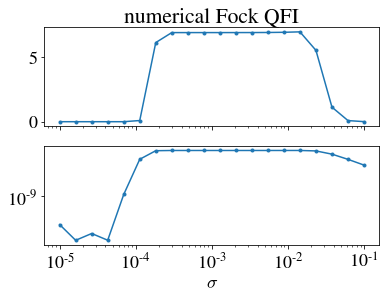

In [19]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].semilogx(sis, fock_data, ".-")
axs[1].loglog(sis, fock_data, ".-")
axs[0].set(title="numerical Fock QFI")
axs[1].set(xlabel=r"$\sigma$")
plt.show()

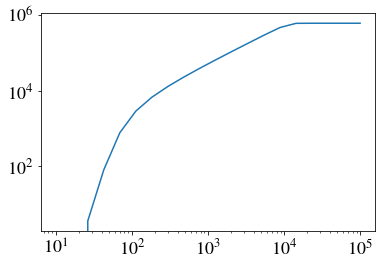

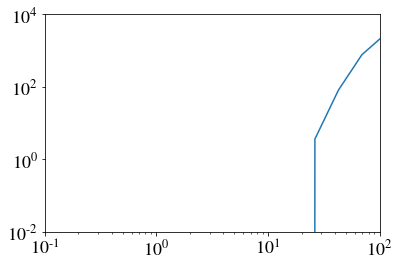

In [21]:
# TODO: compare this to the other states/QFIs
plt.loglog(rs, integral)
plt.show()

# TODO: fix the above bug first since the comparison will only be good for si from 1e-4 to 1e-2 (r from 1e2 to 1e4)
plt.loglog(rs, integral)
plt.xlim(1e-1, 1e2)
plt.ylim(1e-2, 1e4)
plt.show()

Cumulative FI

In [10]:
a = 1
# vacuum, lossless (see Tuvia's notes)
qfi = lambda si: 2 / (1 + si**2)
quad = lambda si: 2 * si**2 / (0.5 + si**2) ** 2
# smsv, lossy
eta_meas = 0.1  # measurement loss
n_input = 10
smsv = lambda si: QFIM_SMSV(si, np.arcsinh(np.sqrt(n_input)), eta_meas)

rs = np.geomspace(1e-2, 1e4, 200)
sis = a / rs
integrands = dict()
# lossy correction to vacuum case
loss_correction = lambda qfi_fn, si: (1 - eta_meas) * qfi_fn(np.sqrt(1 - eta_meas) * si)
integrands["vacuum QFI"] = loss_correction(qfi, sis)
integrands["vacuum quadrature CFI"] = loss_correction(quad, sis)
# loss already included
integrands["SMSV QFI"] = smsv(sis)
# including the 4 pi factor
for k, v in integrands.items():
    integrands[k] = 4 * np.pi * v

# cumulative integral up to a given R
integrals = dict()
for key, value in integrands.items():
    integrals[key] = np.empty_like(rs)
# TODO: write this efficiently to not recalculate the integral up to the previous point
for i in range(len(rs)):
    for key, value in integrals.items():
        value[i] = np.trapz(x=rs[:i], y=integrands[key][:i])

# save dict to .h5
df = pd.DataFrame(integrals)
df["r"] = rs

file = "./data/cumulative_FI.txt"
df.to_csv(file, index=False)

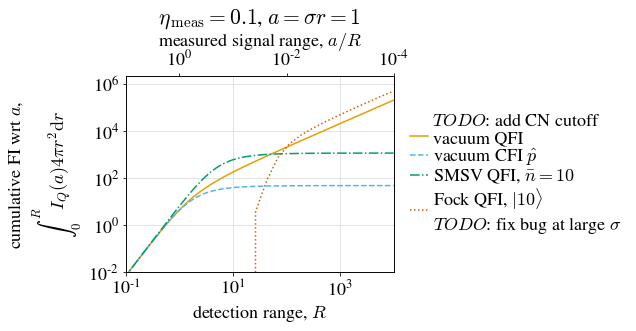

In [37]:
scale_factor = 1.2
fig, ax = plt.subplots(figsize=(4 * scale_factor, 3 * scale_factor))
grid(ax)

c0, c1, c2, c3 = (
    COLOURS["Orange"],
    COLOURS["Sky blue"],
    COLOURS["Bluish green"],
    COLOURS["Vermillion"],
)

ax.loglog(df["r"], df["vacuum QFI"], color=c0, label=r"vacuum QFI")
ax.loglog(
    df["r"],
    df["vacuum quadrature CFI"],
    color=c1,
    linestyle="--",
    label=r"vacuum CFI $\hat p$",
)
ax.loglog(
    df["r"],
    df["SMSV QFI"],
    color=c2,
    linestyle="-.",
    label=rf"SMSV QFI, $\bar n = {n_input}$",
)
ax.loglog(
    df_Fock["r"],
    df_Fock["integrated Fock"],
    color=c3,
    linestyle=":",
    label=rf"Fock QFI, $|{n_input}\rangle$"
    + "\n"
    + r"$\mathit{TODO}$: fix bug at large $\sigma$",
)

xlim = (1e-1, 1e4)
ylim = (1e-2, None)

ax.set(
    title=rf"$\eta_\mathrm{{\,meas}}={eta_meas}$, $a=\sigma r={a}$",
    xlabel=r"detection range, $R$",
    ylabel="cumulative FI wrt $a$,\n" + r"$\int_0^R I_Q(a) 4\pi r^2\mathrm{d}r$",
    xlim=xlim,
    ylim=ylim,
)

# xticks = np.array((min(rs), max(rs)))
# ax.set_xticks(xticks)

ax2 = ax.twiny()
# a / min(rs)
ax2.set(xlabel=r"measured signal range, $a/R$", xlim=a / np.array(xlim), xscale="log")

ax.legend(
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=18,
    # loc="lower right",
    bbox_to_anchor=(1, 0.5),
    loc="center left",
    title=r"$\mathit{TODO}$: add CN cutoff",
)

fig.savefig("./figures/cumulative_FI_lossless.pdf", bbox_inches="tight")
plt.show()

Lossless FI versus sigma

In [51]:
sis = np.linspace(0, 2, 100)
qfis = qfi(sis)
quads = quad(sis)
smsvs = smsv(sis)

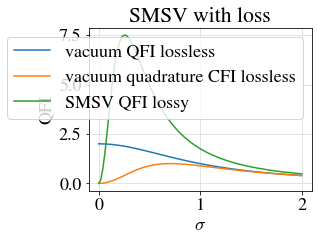

In [55]:
scale_factor = 1
fig, ax = plt.subplots(figsize=(4 * scale_factor, 3 * scale_factor))
grid(ax)

ax.plot(sis, qfis, label="vacuum QFI lossless")
ax.plot(sis, quads, label="vacuum quadrature CFI lossless")
ax.plot(sis, smsvs, label="SMSV QFI lossy")
ax.set(xlabel=r"$\sigma$", ylabel="QFI", title="SMSV with loss")
ax.legend()
plt.show()